In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision

from PIL import Image
from tqdm import tqdm
import os

In [2]:
path ='data/' #set here data directory

In [3]:
#TODO Refactor - split for methods
def get_files_size():
    width = []
    heigth = []
    for direct in os.listdir(path):
        if direct != '.DS_Store': # applicable to MacOS
            for folder in os.listdir(os.path.join(path,direct)):
                if folder != '.DS_Store':
                    for file in os.listdir(os.path.join(path,direct ,folder)):
                        if file != '.DS_Store':
                            width.append(Image.open(os.path.join(path,direct ,folder, file)).size[0])
                            heigth.append(Image.open(os.path.join(path,direct ,folder, file)).size[0])
    return width, heigth

In [4]:
#
width, heigth = get_files_size()
width = round(np.array(width).mean())
heigth =round(np.array(heigth).mean())
print(f'Dimensions for resize \nwidth: {width}')
print(f'heigth: {heigth}')

Dimensions for resize 
width: 250
heigth: 250


In [5]:
#normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((width,heigth)), 
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((width,heigth)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(os.path.join(path,'train'), data_transforms['train']),
    'validation': 
    datasets.ImageFolder(os.path.join(path, 'validation'), data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True), 
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False)
}

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [7]:
model = models.resnet18(weights=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(512, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

## Train

In [9]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [10]:
%%time
model_trained = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train loss: 0.5755, acc: 0.6931
validation loss: 0.4686, acc: 0.7500
Epoch 2/10
----------
train loss: 0.3150, acc: 0.8876
validation loss: 0.2923, acc: 0.9050
Epoch 3/10
----------
train loss: 0.2382, acc: 0.9207
validation loss: 0.2623, acc: 0.8800
Epoch 4/10
----------
train loss: 0.2229, acc: 0.9092
validation loss: 0.3087, acc: 0.8650
Epoch 5/10
----------
train loss: 0.2334, acc: 0.9020
validation loss: 0.2265, acc: 0.9100
Epoch 6/10
----------
train loss: 0.2839, acc: 0.8862
validation loss: 0.3202, acc: 0.8550
Epoch 7/10
----------
train loss: 0.1422, acc: 0.9467
validation loss: 0.2547, acc: 0.8850
Epoch 8/10
----------
train loss: 0.1455, acc: 0.9409
validation loss: 0.2193, acc: 0.9100
Epoch 9/10
----------
train loss: 0.1344, acc: 0.9582
validation loss: 0.3013, acc: 0.8550
Epoch 10/10
----------
train loss: 0.2281, acc: 0.9020
validation loss: 0.2674, acc: 0.8700
CPU times: user 15.9 s, sys: 6.83 s, total: 22.8 s
Wall time: 50 s


## Predict

In [11]:
test_img_paths = ["test/0.jpg",
                        "test/1.jpg",
                        "test/2.jpg"]
img_list = [Image.open(img_path) for img_path in test_img_paths]

In [12]:
#Using same preprocessing as for validation
#Creating one tensor from list of tensors
test_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [13]:
output = model(test_batch)
predictions = F.softmax(output, dim=1).cpu().data.numpy()
predictions

array([[9.6104103e-01, 3.8958922e-02],
       [9.9956006e-01, 4.3992777e-04],
       [7.0567912e-04, 9.9929428e-01]], dtype=float32)

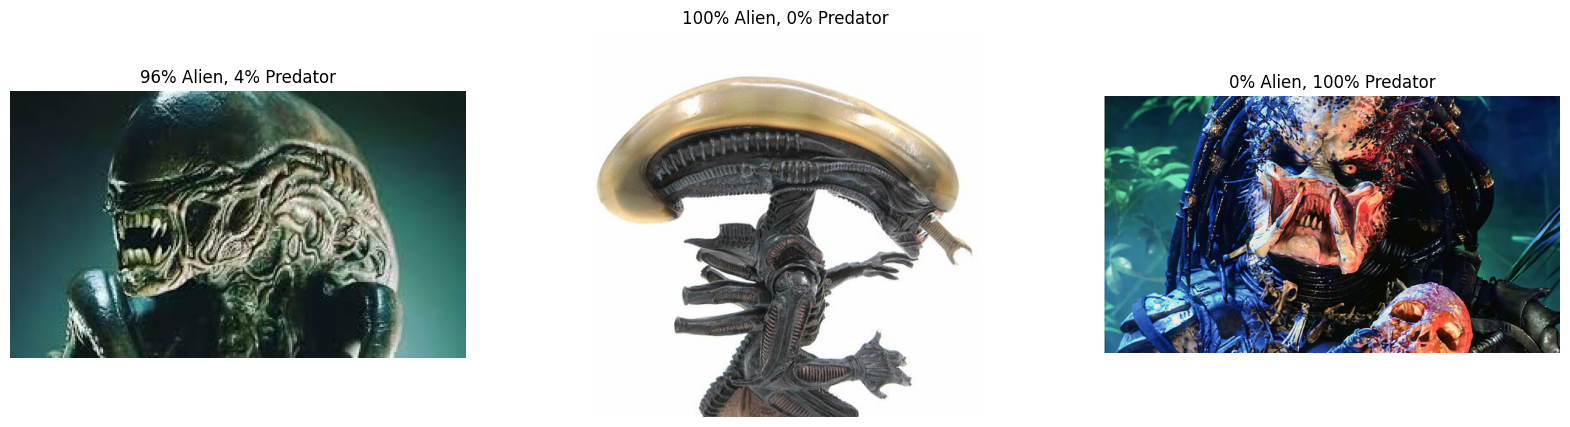

In [14]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*predictions[i,0],
                                                            100*predictions[i,1]))
    ax.imshow(img)